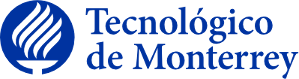

# **Maestría en Inteligencia Artificial Aplicada**

## **Proyecto Integrador - TC5035**

## Semana 4: Avance 2 - Ingeniería de características

### Profesores
- Dra. Grettel Barceló Alonso
- Dr. Luis Eduardo Falcón Morales

### Asesor
- Dr. Gerardo Jesús Camacho González

### Patrocinadores
- Dr. Jorge Antonio Ascencio Gutiérrez
- Yanmei King Loeza

### Equipo 29
- Carolina Lucas Dophe  –  A01702450
- Juan Pablo López Sánchez   –   A01313663
- Víctor Hugo Soto Herrera   –   A01706446

### Fecha de entrega
Domingo 8 de febrero de 2026

### Tabla de contenido
[Introducción](#intro)

1. [Descripción de las fuentes de datos](#fuentes)
2. [Carga de librerías y configuración inicial](#config)
3. [Desagregación temporal de la oferta productiva](#desagregacion)
4. [Exportación de conjunto de datos](#exportacion)
5. [Preparación de los datos e ingeniería de características](#ingenieria)
6. [Selección y reducción de características](#reduccion)

[Conclusiones](#conclusiones)

[Referencias](#ref)

### <a class="anchor" id="intro">Introducción</a>

El presente *notebook* tiene como objetivo documentar y ejecutar la **fase de Preparación de los Datos**, con énfasis en la **ingeniería de características (Feature Engineering)**, dentro del marco metodológico **CRISP-ML**, como paso previo al desarrollo de modelos predictivos de la oferta productiva de aguacate en el estado de Jalisco.

En un entregable previo del proyecto se llevó a cabo la integración, limpieza y análisis exploratorio de datos (EDA) a nivel anual, a partir de diversas fuentes oficiales del Servicio de Información Agroalimentaria y Pesquera (SIAP). Como resultado de dicha etapa, se construyó un conjunto de datos anual consolidado y validado, el cual constituye el punto de partida para el presente análisis.

Dado que los modelos de series de tiempo y otras técnicas de aprendizaje automático se benefician de una mayor granularidad temporal, en este notebook se implementa de manera formal un proceso de **desagregación temporal** que permite estimar una serie mensual de producción a partir de la información anual disponible. Posteriormente, se desarrollan las transformaciones y decisiones propias de la ingeniería de características, las cuales serán justificadas en función del tipo de modelos que se pretenden emplear en etapas posteriores.

### <a class="anchor" id="fuentes">1. Descripción de las fuentes de datos</a>

Si bien el presente notebook hace uso directo de un conjunto de datos ya integrado y depurado, es importante documentar las fuentes originales a partir de las cuales dicho dataset fue construido en un entregable previo del proyecto. Esto garantiza la trazabilidad metodológica y la correcta interpretación de las variables utilizadas en las etapas posteriores de análisis y modelado.

* **Dataset maestro anual de producción de aguacate en Jalisco (1980–2024)**  
  Conjunto de datos integrado y depurado como resultado del entregable previo del proyecto, construido a partir de las fuentes oficiales del SIAP descritas anteriormente. Este dataset consolida la información anual a nivel estatal, por modalidad de producción, y constituye el insumo principal para la desagregación temporal y las etapas posteriores de preparación de datos.

* **Datos Abiertos SIAP – Nivel Estado (1980–2002)** **`+`**
* **Datos Abiertos SIAP – Nivel Municipio (2003–2024)** **`+`**
* **Anuario Estadístico SIAP (1980–2024)** **`+`**

* **Indicador de comercio exterior – Importaciones mensuales de aguacate a Estados Unidos (1996–2024)**  
  Información mensual proveniente del sistema de la U.S. International Trade Commission (USITC), utilizada como indicador auxiliar para capturar la distribución temporal intra–anual de la oferta productiva. Este indicador no se emplea como medida directa del nivel de producción, sino exclusivamente para determinar participaciones relativas mensuales en el proceso de desagregación temporal.[[3](#ref3)]

**`+`** Estas fuentes fueron empleadas durante la etapa previa de integración y EDA anual, y se mencionan aquí con fines de trazabilidad metodológica. [[1](#ref1)] [[2](#ref2)]

### <a class="anchor" id="config">2. Carga de librerías y configuración inicial</a>

En esta sección se cargan las librerías necesarias para el manejo, limpieza, integración y exploración de los datos, así como algunas configuraciones básicas para facilitar la visualización y el análisis posterior.

In [1]:
# Cargar librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
# Configuración de visualización
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
# Definición de rutas base
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# Definición de rutas de archivo generado en Avance 1
ANUAL_FILE = PROCESSED_DATA_DIR / "df_master_jalisco_aguacate_1980_2024.csv"

# Definición de rutas de archivo externo para hacer la estimación mensual
USITC_FILE = RAW_DATA_DIR / "usitc" / "usitc_imports_avocado_monthly.csv"

### <a class="anchor" id="desagregacion">3. Desagregación temporal de oferta productiva</a>

Esta sección presenta la metodología y el procedimiento empleados para desagregar la producción anual de aguacate a una frecuencia mensual, preservando los totales anuales y utilizando un indicador externo de mayor granularidad temporal.

#### 3.1 Motivación y justificación metodológica

La información productiva disponible para el cultivo de aguacate en el estado de Jalisco se encuentra principalmente agregada a nivel anual, lo cual limita el análisis de dinámicas intra–anuales y la aplicación de modelos de series de tiempo que se benefician de una mayor granularidad temporal. Sin embargo, el objetivo del proyecto es modelar y analizar la evolución temporal de la oferta productiva, por lo que resulta conveniente contar con una aproximación mensual de dicha variable.

Dado que no se dispone de registros oficiales de producción mensual a nivel estatal, se adopta una estrategia de desagregación temporal que permite distribuir la producción anual en una serie mensual, preservando los totales anuales originales. Esta aproximación es común en estudios económicos y agrícolas cuando existen series de baja frecuencia para la variable de interés, pero se cuenta con indicadores auxiliares de mayor frecuencia que reflejan su comportamiento temporal.

#### 3.2 Fuente del indicador

Como indicador auxiliar para la desagregación temporal se emplea información mensual de importaciones de aguacate de origen mexicano hacia Estados Unidos, obtenida del sistema de comercio internacional de la U.S. International Trade Commission (USITC)[[3](#ref3)]. Este indicador se selecciona debido a la alta correlación esperada entre los volúmenes exportados y la dinámica productiva nacional, considerando que México es el principal proveedor de aguacate al mercado estadounidense.

Si bien las importaciones reportadas no corresponden exclusivamente al estado de Jalisco, los principales estados productores y exportadores de aguacate (particularmente Jalisco y Michoacán) presentan condiciones agroclimáticas similares y ciclos productivos comparables. En este contexto, el indicador se utiliza únicamente en términos relativos, es decir, para capturar la distribución temporal mensual (% de participación por mes), y no como una medida directa del nivel de producción estatal.

#### 3.3 Metodología de desagregación temporal (Denton proporcional)

La desagregación temporal de la serie anual de producción se realiza mediante un enfoque de tipo Denton proporcional en su variante de preservación de totales, una técnica ampliamente utilizada para distribuir series de baja frecuencia en series de mayor frecuencia utilizando un indicador externo. Este método permite preservar los totales anuales observados, al mismo tiempo que incorpora la estructura temporal del indicador mensual seleccionado.

En particular, la producción anual de aguacate se distribuye a nivel mensual de acuerdo con la participación relativa de cada mes en el indicador de importaciones, garantizando que la suma de los valores mensuales reproduzca exactamente el valor anual original. Esta estrategia corresponde a una forma pragmática de temporal disaggregation using indicators, adecuada cuando el objetivo principal es obtener una aproximación consistente de la dinámica intra–anual sin introducir supuestos adicionales sobre el nivel absoluto de la variable desagregada.

#### 3.4 Construcción del dataset mensual

A partir del conjunto de datos anual consolidado, se construye un dataset de frecuencia mensual mediante la aplicación del esquema de desagregación temporal descrito en la sección anterior. Para ello, cada observación anual de producción se expande en doce registros mensuales, incorporando explícitamente la variable Mes y manteniendo las dimensiones originales del conjunto de datos, como el año y la modalidad de producción.

El proceso consiste en asignar a cada mes una fracción del volumen anual total, determinada por la participación relativa mensual del indicador externo. De esta manera, se obtiene una serie mensual de producción que reproduce exactamente los totales anuales originales y que refleja la estacionalidad implícita en el comportamiento del comercio exterior. Con fines de trazabilidad, las observaciones resultantes se identifican como datos estimados y se distingue explícitamente la frecuencia temporal de la información.

In [4]:
# Cargar datos anuales procesados
df_master_anual = pd.read_csv(ANUAL_FILE, encoding="utf-8-sig")
df_master_anual.shape

(90, 9)

In [5]:
# Mostrar las primeras filas del DataFrame
df_master_anual.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio
0,1980,Riego,"2,490.00","2,210.00",0.00,"22,100.00","442,000.00",10.00,20.00
1,1980,Temporal,760.00,675.00,0.00,"6,277.00","125,540.00",9.30,20.00
2,1981,Riego,"2,545.00","2,498.00",0.00,"24,705.00","551,366.00",9.89,22.32
3,1981,Temporal,645.00,623.00,0.00,"3,739.00","83,447.00",6.00,22.32
4,1982,Riego,"2,545.00","2,508.00",0.00,"24,964.00","617,060.00",9.95,24.72


In [6]:
# Mostrar información del DataFrame
df_master_anual.info()

<class 'pandas.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               90 non-null     int64  
 1   Nommodalidad       90 non-null     str    
 2   Sembrada           90 non-null     float64
 3   Cosechada          90 non-null     float64
 4   Siniestrada        90 non-null     float64
 5   Volumenproduccion  90 non-null     float64
 6   Valorproduccion    90 non-null     float64
 7   Rendimiento        90 non-null     float64
 8   Precio             90 non-null     float64
dtypes: float64(7), int64(1), str(1)
memory usage: 6.5 KB


In [7]:
# Cargar datos del USITC
df_indicador_raw = pd.read_csv(USITC_FILE, encoding="utf-8-sig")
df_indicador_raw.shape

(406, 6)

In [8]:
# Mostrar las primeras filas del DataFrame
df_indicador_raw.head()

,Data Type,Year,Month,Quantity Description,General First Unit of Quantity,Suppressed
0,General First Unit of Quantity,1990,4,kilograms,81,0
1,General First Unit of Quantity,1990,8,kilograms,3495,0
2,General First Unit of Quantity,1990,9,kilograms,4407,0
3,General First Unit of Quantity,1990,10,kilograms,11132,0
4,General First Unit of Quantity,1990,12,kilograms,2248,0


In [9]:
# Mostrar información del DataFrame
df_indicador_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Data Type                       406 non-null    str  
 1   Year                            406 non-null    int64
 2   Month                           406 non-null    int64
 3   Quantity Description            406 non-null    str  
 4   General First Unit of Quantity  406 non-null    int64
 5   Suppressed                      406 non-null    int64
dtypes: int64(4), str(2)
memory usage: 19.2 KB


In [10]:
# Normalizar el indicador mensual para obtener participaciones relativas por año
df_indicador = (
    df_indicador_raw
    .rename(columns={
        "Year": "Anio",
        "Month": "Mes",
        "General First Unit of Quantity": "Volumen_importado"
    })
    [["Anio", "Mes", "Volumen_importado"]]
)

# Asegurar tipos
df_indicador["Anio"] = df_indicador["Anio"].astype(int)
df_indicador["Mes"] = df_indicador["Mes"].astype(int)
df_indicador["Volumen_importado"] = pd.to_numeric(
    df_indicador["Volumen_importado"],
    errors="coerce"
)

# Revisar el DataFrame final
df_indicador.info()

<class 'pandas.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Anio               406 non-null    int64
 1   Mes                406 non-null    int64
 2   Volumen_importado  406 non-null    int64
dtypes: int64(3)
memory usage: 9.6 KB


**`NOTA`**: Debido a la cobertura mensual incompleta del indicador en los primeros años disponibles, la desagregación temporal se aplica únicamente a los años con información mensual completa. En consecuencia, el análisis mensual se realiza a partir de **`1996`**, mientras que los años previos se conservan exclusivamente a nivel anual como referencia histórica.

In [11]:
# Definir año de inicio para análisis mensual
START_YEAR_MENSUAL = 1996

df_indicador = df_indicador[df_indicador["Anio"] >= START_YEAR_MENSUAL].copy()

# Checar años con cobertura mensual completa
valid_years = (
    df_indicador
    .groupby("Anio")["Mes"]
    .nunique()
    .loc[lambda x: x == 12]
    .index
)

df_indicador = df_indicador[df_indicador["Anio"].isin(valid_years)]

In [12]:
# Cálculo de Denton Proporcional en su variante de preservación de totales para desagregar series temporales

# Calcular participación mensual por año
df_indicador["share_mes"] = (
    df_indicador
    .groupby("Anio")["Volumen_importado"]
    .transform(lambda x: x / x.sum())
)

# Validación rápida: la suma por año debe ser 1
(
    df_indicador
    .groupby("Anio")["share_mes"]
    .sum()
    .describe()
)

count   29.00
mean     1.00
std      0.00
min      1.00
25%      1.00
50%      1.00
75%      1.00
max      1.00
Name: share_mes, dtype: float64

In [13]:
# Filtrar df_master_anual para años con datos mensuales completos
df_master_anual_mensual = (
    df_master_anual
    [df_master_anual["Anio"].isin(valid_years)]
    .copy()
)

# Merge anual × mensual (por año)
df_mensual_raw = (
    df_master_anual_mensual
    .merge(
        df_indicador[["Anio", "Mes", "share_mes"]],
        on="Anio",
        how="inner"
    )
)

# Mostrar las primeras filas del DataFrame
df_mensual_raw.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes
0,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",1,0.06
1,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",2,0.07
2,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",3,0.09
3,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",4,0.10
4,1996,Riego,982.00,555.00,0.00,"6,106.00","10,117,642.00",11.00,"1,657.00",5,0.12


In [14]:
# Deasignación mensual de las variables anuales
df_mensual_raw["Volumenproduccion"] = (
    df_mensual_raw["Volumenproduccion"] * df_mensual_raw["share_mes"]
)

In [15]:
# 
df_mensual_raw["Frecuencia"] = "Mensual"
df_mensual_raw["TipoDato"] = "Estimado"

# Ordenar para legibilidad
df_master_mensual = df_mensual_raw.sort_values(
    ["Anio", "Mes", "Nommodalidad"]
).reset_index(drop=True)

df_master_mensual.head(12)

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes,Frecuencia,TipoDato
0,1996,Riego,982.00,555.00,0.00,360.67,"10,117,642.00",11.00,"1,657.00",1,0.06,Mensual,Estimado
1,1996,Temporal,58.00,58.00,0.00,25.34,"710,853.00",7.40,"1,657.00",1,0.06,Mensual,Estimado
2,1996,Riego,982.00,555.00,0.00,447.64,"10,117,642.00",11.00,"1,657.00",2,0.07,Mensual,Estimado
3,1996,Temporal,58.00,58.00,0.00,31.45,"710,853.00",7.40,"1,657.00",2,0.07,Mensual,Estimado
4,1996,Riego,982.00,555.00,0.00,566.33,"10,117,642.00",11.00,"1,657.00",3,0.09,Mensual,Estimado
5,1996,Temporal,58.00,58.00,0.00,39.79,"710,853.00",7.40,"1,657.00",3,0.09,Mensual,Estimado
6,1996,Riego,982.00,555.00,0.00,594.51,"10,117,642.00",11.00,"1,657.00",4,0.10,Mensual,Estimado
7,1996,Temporal,58.00,58.00,0.00,41.77,"710,853.00",7.40,"1,657.00",4,0.10,Mensual,Estimado
8,1996,Riego,982.00,555.00,0.00,712.07,"10,117,642.00",11.00,"1,657.00",5,0.12,Mensual,Estimado
9,1996,Temporal,58.00,58.00,0.00,50.03,"710,853.00",7.40,"1,657.00",5,0.12,Mensual,Estimado


In [16]:
# Reagregar mensual -> anual
check_totals = (
    df_master_mensual
    .groupby(["Anio", "Nommodalidad"], as_index=False)["Volumenproduccion"]
    .sum()
    .merge(
        df_master_anual_mensual,
        on=["Anio", "Nommodalidad"],
        suffixes=("_mensual", "_anual")
    )
)

check_totals["diff"] = (
    check_totals["Volumenproduccion_mensual"]
    - check_totals["Volumenproduccion_anual"]
)

check_totals["diff"].describe()

count   58.00
mean     0.00
std      0.00
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      0.00
Name: diff, dtype: float64

In [17]:
# Verificar información del DataFrame final
df_master_mensual.info()

<class 'pandas.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    str    
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Siniestrada        696 non-null    float64
 5   Volumenproduccion  696 non-null    float64
 6   Valorproduccion    696 non-null    float64
 7   Rendimiento        696 non-null    float64
 8   Precio             696 non-null    float64
 9   Mes                696 non-null    int64  
 10  share_mes          696 non-null    float64
 11  Frecuencia         696 non-null    str    
 12  TipoDato           696 non-null    str    
dtypes: float64(8), int64(2), str(3)
memory usage: 70.8 KB


**`NOTA`**: La serie mensual obtenida mediante este procedimiento debe interpretarse como una aproximación estimada de la dinámica temporal de la producción, utilizada con fines analíticos y de modelado, y no como una medición directa de producción observada a nivel mensual.

#### 3.5 Validaciones y consistencia temporal

En esta sección se realizan validaciones cuantitativas y visuales para verificar la consistencia, coherencia y calidad de la serie mensual estimada a partir del proceso de desagregación temporal.

##### Preservación de totales anuales

Se verifica que la agregación de la serie mensual reproduzca exactamente los valores anuales originales de producción, condición fundamental del método de desagregación empleado.

In [18]:
# Agregar mensual -> anual
df_mensual_agregado = (
    df_master_mensual
    .groupby("Anio", as_index=False)["Volumenproduccion"]
    .sum()
    .rename(columns={"Volumenproduccion": "Volumen_mensual_agregado"})
)

# Filtrar anual al mismo rango temporal
df_anual_comp = (
    df_master_anual
    [df_master_anual["Anio"] >= 1996]
    .groupby("Anio", as_index=False)["Volumenproduccion"]
    .sum()
    .rename(columns={"Volumenproduccion": "Volumen_anual_observado"})
)

# Unir para comparación
df_check = df_anual_comp.merge(
    df_mensual_agregado,
    on="Anio",
    how="inner"
)

df_check.head()

,Anio,Volumen_anual_observado,Volumen_mensual_agregado
0,1996,"6,535.00","6,535.00"
1,1997,"6,739.00","6,739.00"
2,1998,"4,985.00","4,985.00"
3,1999,"5,565.00","5,565.00"
4,2000,"5,213.00","5,213.00"


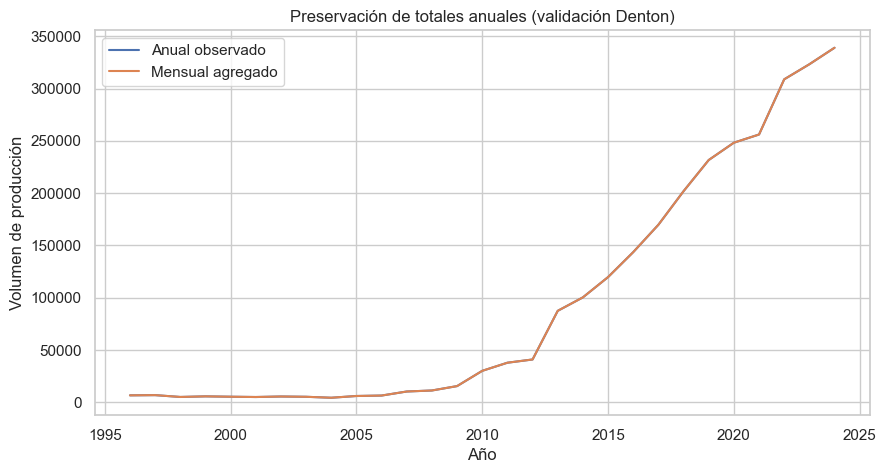

In [19]:
# Gráfica de validación
plt.figure()
plt.plot(df_check["Anio"], df_check["Volumen_anual_observado"], label="Anual observado")
plt.plot(df_check["Anio"], df_check["Volumen_mensual_agregado"], label="Mensual agregado")
plt.xlabel("Año")
plt.ylabel("Volumen de producción")
plt.title("Preservación de totales anuales (validación Denton)")
plt.legend()
plt.show()

##### Estacionalidad mensual promedio

Se analiza la distribución promedio de la producción a lo largo del año con el fin de identificar patrones estacionales implícitos y validar que la estructura temporal resultante sea razonable.

In [20]:
# Calcular estacionalidad promedio
df_estacionalidad = (
    df_master_mensual
    .groupby("Mes", as_index=False)["share_mes"]
    .mean()
)

df_estacionalidad

,Mes,share_mes
0,1,0.13
1,2,0.10
2,3,0.10
3,4,0.09
4,5,0.06
5,6,0.05
6,7,0.04
7,8,0.05
8,9,0.06
9,10,0.08


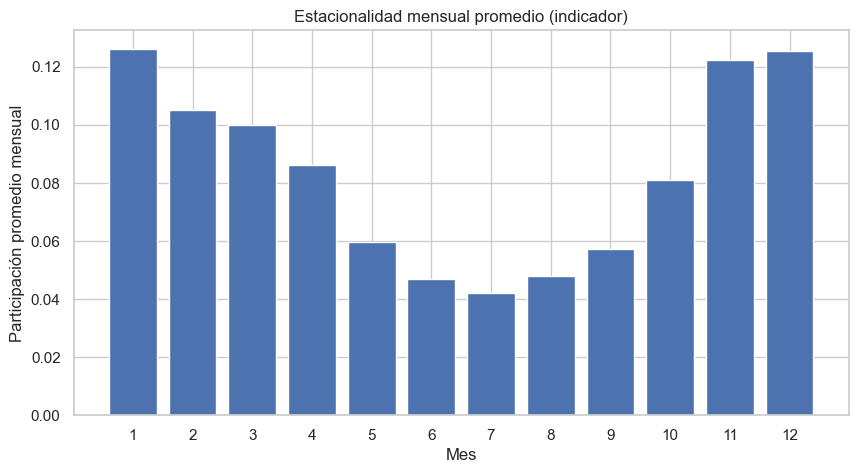

In [21]:
# Gráfica de estacionalidad mensual promedio
plt.figure()
plt.bar(df_estacionalidad["Mes"], df_estacionalidad["share_mes"])
plt.xlabel("Mes")
plt.ylabel("Participación promedio mensual")
plt.title("Estacionalidad mensual promedio (indicador)")
plt.xticks(range(1, 13))
plt.show()

##### Revisión visual de la serie mensual completa

Se examina la serie mensual completa mediante visualización gráfica para detectar posibles discontinuidades, valores atípicos o comportamientos anómalos derivados del proceso de estimación.

In [22]:
# Crear columna de fecha para graficar
df_master_mensual["Fecha"] = pd.to_datetime(
    dict(year=df_master_mensual["Anio"], month=df_master_mensual["Mes"], day=1)
)

# Agregar por mes (si hay modalidad)
df_mensual_total = (
    df_master_mensual
    .groupby("Fecha", as_index=False)["Volumenproduccion"]
    .sum()
)

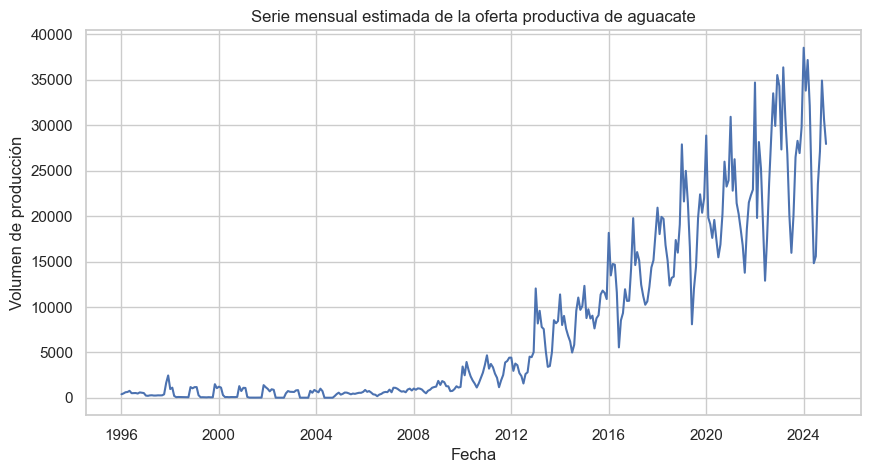

In [23]:
# Gráfica de la serie mensual estimada
plt.figure()
plt.plot(df_mensual_total["Fecha"], df_mensual_total["Volumenproduccion"])
plt.xlabel("Fecha")
plt.ylabel("Volumen de producción")
plt.title("Serie mensual estimada de la oferta productiva de aguacate")
plt.show()

### <a class="anchor" id="exportacion">4. Exportación de conjunto de datos</a>

Una vez concluida la etapa de integración y homologación de datos, el conjunto de datos resultante se exporta para su reutilización en las etapas posteriores de análisis exploratorio, ingeniería de características y modelado.

In [24]:
# Guardar DataFrame mensual maestro a CSV
df_master_mensual.to_csv(
    PROCESSED_DATA_DIR / "df_master_estimacion_mensual_jalisco_aguacate_1996_2024.csv",
    index=False
)

### <a class="anchor" id="ingenieria">5. Preparación de los datos e ingeniería de características</a>

En esta sección se documentan las decisiones metodológicas orientadas a transformar el conjunto de datos mensual en una representación adecuada para el modelado predictivo, incluyendo la depuración de variables, la generación de nuevas características y la aplicación de transformaciones estadísticas. El objetivo es mejorar la calidad, interpretabilidad y utilidad del dataset sin introducir sesgos o filtraciones de información hacia la variable objetivo.

#### 5.1 Revisión estructural del dataset mensual

Se realiza una inspección general de la estructura del conjunto de datos mensual, incluyendo tipos de variables, dimensiones, frecuencia temporal y consistencia interna, con el fin de identificar diferencias relevantes respecto al dataset anual y establecer una base clara para las transformaciones posteriores.

In [25]:
# Vista inicial del dataset mensual
df = pd.read_csv(PROCESSED_DATA_DIR / "df_master_estimacion_mensual_jalisco_aguacate_1996_2024.csv")
df.head()

,Anio,Nommodalidad,Sembrada,Cosechada,Siniestrada,Volumenproduccion,Valorproduccion,Rendimiento,Precio,Mes,share_mes,Frecuencia,TipoDato,Fecha
0,1996,Riego,982.00,555.00,0.00,360.67,"10,117,642.00",11.00,"1,657.00",1,0.06,Mensual,Estimado,1996-01-01
1,1996,Temporal,58.00,58.00,0.00,25.34,"710,853.00",7.40,"1,657.00",1,0.06,Mensual,Estimado,1996-01-01
2,1996,Riego,982.00,555.00,0.00,447.64,"10,117,642.00",11.00,"1,657.00",2,0.07,Mensual,Estimado,1996-02-01
3,1996,Temporal,58.00,58.00,0.00,31.45,"710,853.00",7.40,"1,657.00",2,0.07,Mensual,Estimado,1996-02-01
4,1996,Riego,982.00,555.00,0.00,566.33,"10,117,642.00",11.00,"1,657.00",3,0.09,Mensual,Estimado,1996-03-01


In [26]:
# Porcentaje de valores faltantes
num_rows = df.shape[0]
print("Valores nulos:\n")

for col in df.columns:
    na = ((df[col].notna().count() - num_rows) * 100) / num_rows
    print(f'{col}: {na}')

Valores nulos:

Anio: 0.0
Nommodalidad: 0.0
Sembrada: 0.0
Cosechada: 0.0
Siniestrada: 0.0
Volumenproduccion: 0.0
Valorproduccion: 0.0
Rendimiento: 0.0
Precio: 0.0
Mes: 0.0
share_mes: 0.0
Frecuencia: 0.0
TipoDato: 0.0
Fecha: 0.0


Para este dataset no se cuentan con datos faltantes en ninguna columna, lo cual es de mucha ayuda para ahorrarnos el proceso de imputar datos o deshacernos de columnas severamente dañadas.

In [27]:
# Información estructural del dataset
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    str    
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Siniestrada        696 non-null    float64
 5   Volumenproduccion  696 non-null    float64
 6   Valorproduccion    696 non-null    float64
 7   Rendimiento        696 non-null    float64
 8   Precio             696 non-null    float64
 9   Mes                696 non-null    int64  
 10  share_mes          696 non-null    float64
 11  Frecuencia         696 non-null    str    
 12  TipoDato           696 non-null    str    
 13  Fecha              696 non-null    str    
dtypes: float64(8), int64(2), str(4)
memory usage: 76.3 KB


En nuestro dataset se puede observar que en su mayoría está compuesto por variables numéricas, siendo `Anio` y `Mes`, las únicas columnas con valores numéricos enteros, mientras que el resto son valores con decimales. La columna `Nommodalidad` es la principal variable categórica del conjunto de datos, acompañada por variables descriptivas adicionales como `Frecuencia` y `TipoDato`.

In [28]:
# Estadísticas descriptivas de variables numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Anio,696.00,"2,010.00",8.37,"1,996.00","2,003.00","2,010.00","2,017.00","2,024.00"
Sembrada,696.00,"5,607.68","7,542.26",55.00,540.00,"3,186.27","5,479.01","27,627.94"
Cosechada,696.00,"4,334.14","6,541.05",55.00,438.50,"1,624.62","3,559.33","25,634.31"
Siniestrada,696.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Volumenproduccion,696.00,"3,930.35","6,828.98",0.65,238.08,"1,017.17","2,822.03","35,712.53"
Valorproduccion,696.00,"956,226,081.55","1,970,385,796.65","710,853.00","18,447,600.36","129,217,576.81","652,205,681.80","8,580,088,223.56"
Rendimiento,696.00,9.29,1.66,5.33,8.27,9.19,10.26,12.38
Precio,696.00,"12,050.84","7,354.58","1,657.00","5,885.34","11,214.66","16,145.98","32,102.94"
Mes,696.00,6.50,3.45,1.00,3.75,6.50,9.25,12.00
share_mes,696.00,0.08,0.05,0.00,0.06,0.08,0.10,0.36


En las estadísticas generales de las variables numéricas, se puede observar que la variable `Siniestrada` solo tiene valores de 0, ya que tanto su mínimo como su máximo tienen el mismo valor de 0, lo que indica que en nuestro dataset no existen registros que contemplen cantidad de territorio dañado. Por esto mismo es que se eliminará esta variable por no aportar ningún valor a nuestro dataset.

Eso lo haremos en la siguiente sección.

#### 5.2 Selección y depuración de variables

En esta etapa se realiza la selección y depuración de variables con el objetivo de conservar únicamente aquellas características que aportan información relevante para el modelado de la oferta productiva, evitando redundancias y posibles fugas de información hacia la variable objetivo.

Dado que el objetivo del proyecto es estimar el volumen de producción, se eliminan variables monetarias y derivadas que podrían introducir dependencia directa con la variable objetivo o no ser observables de forma exógena en un escenario real de predicción. Asimismo, se descartan variables administrativas o descriptivas que no aportan valor explicativo al proceso de modelado.

**Variables a eliminar:**

* `Valorproduccion`
  * Derivada directamente de `Volumenproduccion × Precio`.
* `Precio`
  * Variable monetaria, no determinante directa de la oferta física.
* `Siniestrada`
  * No presenta variabilidad (siempre es cero).
* `TipoDato`, `Frecuencia`
  * Metadatos del proceso de construcción del dataset.
* `share_mes`
  * Variable instrumental usada solo para la desagregación temporal.
* `Fecha`
  * Puede reconstruirse a partir de `Anio` y `Mes`.

La selección se realiza antes de cualquier transformación para evitar propagar ruido o dependencia a etapas posteriores.

In [ ]:
# Copia del dataset para features engineering
df_fe = df.copy()

# Variables a eliminar
cols_to_drop = [
    "Valorproduccion",
    "Precio",
    "Siniestrada",
    "TipoDato",
    "Frecuencia",
    "share_mes"
]

# Eliminar columnas existentes
df_fe = df_fe.drop(columns=[c for c in cols_to_drop if c in df_fe.columns], errors="ignore")

df_fe.info()

<class 'pandas.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Anio               696 non-null    int64  
 1   Nommodalidad       696 non-null    str    
 2   Sembrada           696 non-null    float64
 3   Cosechada          696 non-null    float64
 4   Volumenproduccion  696 non-null    float64
 5   Rendimiento        696 non-null    float64
 6   Mes                696 non-null    int64  
 7   Fecha              696 non-null    str    
dtypes: float64(4), int64(2), str(2)
memory usage: 43.6 KB


Tras la depuración, el conjunto de datos conserva únicamente variables productivas, temporales y categóricas directamente relacionadas con la dinámica de la oferta, reduciendo el riesgo de fuga de información y mejorando la interpretabilidad y robustez de los modelos a implementar.

Estas decisiones se alinean con un escenario realista de predicción, donde variables monetarias o agregadas ex post no estarían disponibles al momento de estimar la producción futura.

#### 5.3 Tranformaciones de variables numéricas

Se aplican transformaciones estadísticas a las variables numéricas con el fin de reducir asimetrías, estabilizar la varianza y facilitar el aprendizaje de los modelos, retomando criterios identificados en el análisis exploratorio previo y adaptándolos al contexto de la serie mensual estimada.

In [30]:
# Código

#### 5.4 Codificación y variables temporales

Las variables categóricas y temporales se transforman a representaciones numéricas adecuadas para su uso en modelos de aprendizaje automático y series de tiempo, incorporando información explícita sobre modalidad de producción y estacionalidad mensual.

In [31]:
# Código

#### 5.5 Escalamiento / normalización

Se aplica el escalamiento de las variables numéricas en una versión paralela del dataset, con el objetivo de facilitar su uso en modelos sensibles a la magnitud de las variables, manteniendo al mismo tiempo una versión no escalada para técnicas que no requieren normalización.

In [32]:
# Código

### <a class="anchor" id="reduccion">6. Selección y reducción de características</a>

En esta sección se evalúa la relevancia y redundancia de las características generadas, mediante análisis de correlación y consideraciones de interpretabilidad, con el objetivo de definir el conjunto final de variables a utilizar en los modelos predictivos. A diferencia de la [sección 5](#ingenieria), aquí no se crean nuevas variables, sino que se decide cuáles se conservan.

xxxx

In [33]:
# Codigo

## <a class="anchor" id="conclusiones">Conclusiones</a>

Pendiente

## <a class="anchor" id="ref">Referencias</a>

[<a class="anchor" id="ref1">1</a>] Secretaría de Agricultura y Desarrollo Rural, “Cierre agrícola,” *AGRICULTURA*, s.f. [En línea].
Disponible en: https://nube.agricultura.gob.mx/cierre_agricola/. Accedido: 26-ene.-2026.

[<a class="anchor" id="ref2">2</a>] Secretaría de Agricultura y Desarrollo Rural, “Datos abiertos del sector agrícola,” *AGRICULTURA*, s.f.
[En línea]. Disponible en: https://nube.agricultura.gob.mx/datosAbiertos/Agricola.php. Accedido: 26-
ene.-2026.

[<a class="anchor" id="ref3">3</a>] United States International Trade Commission (USITC), “DataWeb: Importaciones generales por HTS,” *USITC*, s. f. [En línea]. Disponible en: https://dataweb.usitc.gov/trade/search/GenImp/HTS. Accedido: 28-ene.-2026.

[<a class="anchor" id="ref4">4</a>]  *S. Galli, Python Feature Engineering Cookbook: Over 70 recipes for creating, engineering, and transforming features to build machine learning models*, 2nd ed. Birmingham, UK: Packt Publishing, 2022.